# Project Recommendation System Dicoding - Optra Dananjaya

#Import Library

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Data Loading

Pada bagian ini mempersiapkan fondasi sistem rekomendasi film dengan menyediakan data yang dibutuhkan. Dataset MovieLens "ml-latest-small" diunduh dari Grouplens dan dipilih karena ukurannya yang ramah untuk pengolahan di Google Colab. Setelah diunduh dan diekstrak, empat file CSV utama, yaitu ratings.csv, tags.csv, movies.csv, dan links.csv, dimuat ke dalam DataFrame pandas. File-file ini berisi informasi tentang rating pengguna, tag film, detail film, dan tautan ke sumber eksternal.

DataFrame yang dihasilkan menyimpan data penting tentang interaksi pengguna dengan film, karakteristik film, dan informasi tambahan. Data ini akan menjadi bahan baku untuk analisis dan pemodelan selanjutnya. Dengan memahami data ini, kita dapat mengungkap pola dan hubungan yang tersembunyi, yang akan menjadi dasar untuk membangun sistem rekomendasi yang akurat dan personal.

Tautan Dataset: https://grouplens.org/datasets/movielens/
Dataset ini mencakup data dari 610 pengguna yang memberikan 100.836 penilaian dan 3.683 tag pada 9.742 film. Data tersebut dikumpulkan selama periode 29 Maret 1996 hingga 24 September 2018, dan dataset ini dirilis pada 26 September 2018.

In [51]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2025-05-12 07:39:02--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip.1’

ml-latest-small.zip 100%[===================>] 955.28K  5.10MB/s    in 0.2s    

2025-05-12 07:39:02 (5.10 MB/s) - ‘ml-latest-small.zip.1’ saved [978202/978202]



In [52]:
!unzip /content/ml-latest-small.zip

Archive:  /content/ml-latest-small.zip
replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ALL
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [53]:
# Memuat setiap file ke dalam DataFrame pandas
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
links = pd.read_csv('ml-latest-small/links.csv')

# Data Undertsanding

In [54]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [55]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [56]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [57]:
tags.describe()

,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09


In [58]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [59]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [60]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [61]:
links.describe()

,movieId,imdbId,tmdbId
count,9742.000000,9.742000e+03,9734.000000
mean,42200.353623,6.771839e+05,55162.123793
std,52160.494854,1.107228e+06,93653.481487
min,1.000000,4.170000e+02,2.000000
25%,3248.250000,9.518075e+04,9665.500000
50%,7300.000000,1.672605e+05,16529.000000
75%,76232.000000,8.055685e+05,44205.750000
max,193609.000000,8.391976e+06,525662.000000


In [62]:
ratings['rating'].describe()

,rating
count,100836.000000
mean,3.501557
std,1.042529
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


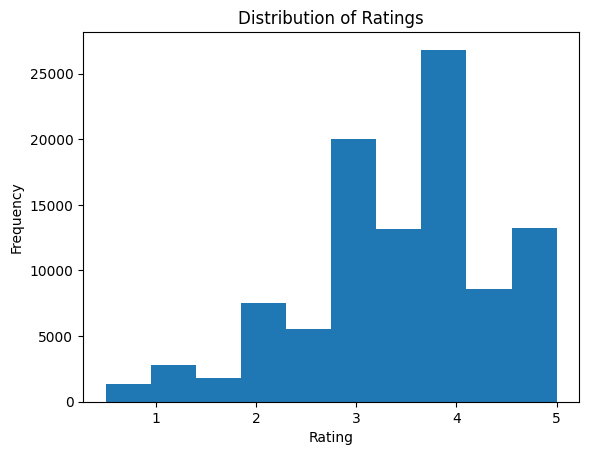

In [63]:
plt.hist(ratings['rating'], bins=10)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

Dari visualisasi diatas,persebaran data rating tidak cukup merata. Rating dengan jumlah terbanyak berada pada rating 3 hingga 4, lalu untuk rating dengan jumlah terendah adalah 0 hingga 2.

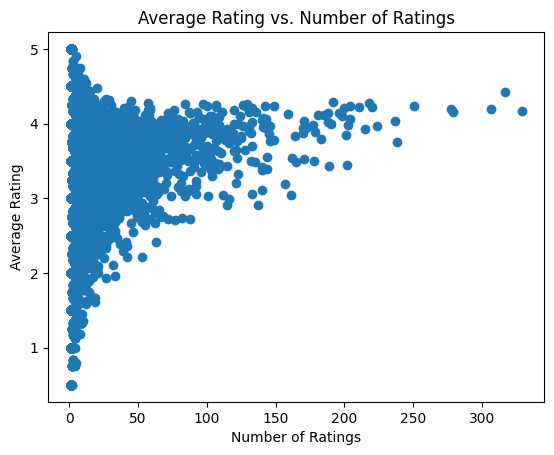

In [64]:
# Menghitung jumlah rating per film
rating_counts = ratings.groupby('movieId')['rating'].count()

# Menghitung rating rata-rata per film
average_ratings = ratings.groupby('movieId')['rating'].mean()

# Membuat scatter plot
plt.scatter(rating_counts, average_ratings)
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.title('Average Rating vs. Number of Ratings')
plt.show()

Sebagian besar titik terkonsentrasi di sebelah kiri grafik (jumlah rating sedikit), menandakan bahwa mayoritas film hanya mendapat sedikit rating.

Ada pola menyebar di mana beberapa film dengan sedikit rating memiliki nilai rata-rata sangat tinggi atau sangat rendah, yang artinya rating tersebut bisa bias karena hanya sedikit orang yang memberi penilaian.

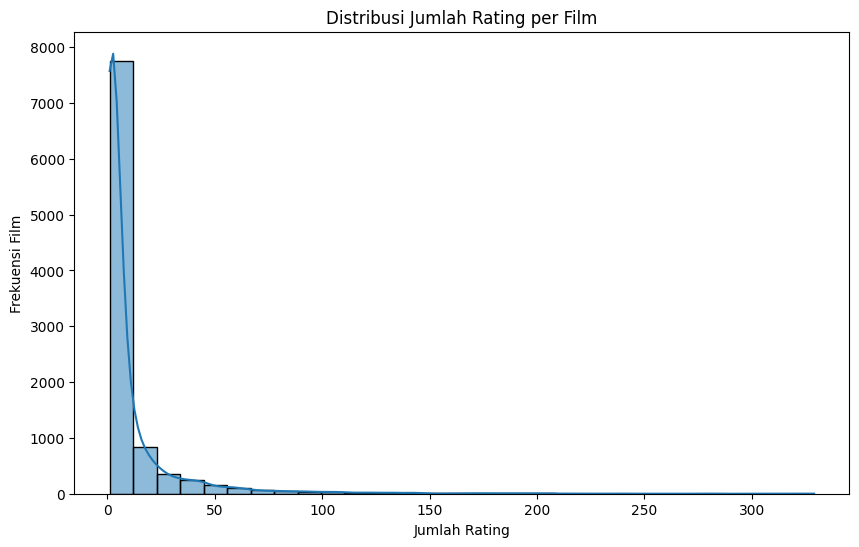

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: count, dtype: float64


In [65]:
# Menghitung frekuensi jumlah rating per film
film_rating_counts = ratings['movieId'].value_counts()

# Membuat histogram distribusi jumlah rating per film
plt.figure(figsize=(10, 6))
sns.histplot(film_rating_counts, bins=30, kde=True)
plt.title('Distribusi Jumlah Rating per Film')
plt.xlabel('Jumlah Rating')
plt.ylabel('Frekuensi Film')  # Mengubah label sumbu y
plt.show()

# Menghitung statistik deskriptif jumlah rating per film
film_rating_stats = film_rating_counts.describe()
print(film_rating_stats)

Grafik menunjukkan bahwa sebagian besar film memiliki jumlah rating yang sedikit.

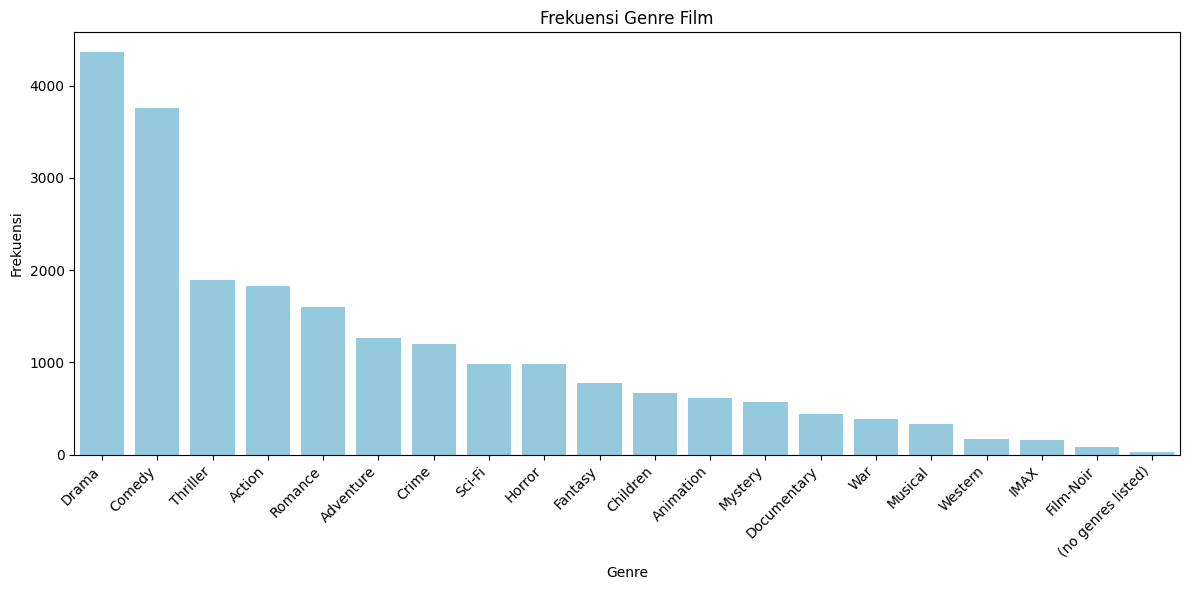

In [66]:
# Memisahkan genre dan menghitung frekuensi
all_genres = []
for index, row in movies.iterrows():
    genres = row['genres'].split('|')
    all_genres.extend(genres)

genre_counts = pd.Series(all_genres).value_counts()

# Membuat grafik frekuensi genre
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, color='skyblue')
plt.title('Frekuensi Genre Film')
plt.xlabel('Genre')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Hasil dari analisis frekuensi genre menunjukkan bahwa Drama merupakan genre yang paling dominan dalam dataset, muncul sebanyak 4.362 kali, diikuti oleh Comedy sebanyak 3.377 kali dan Action sebanyak 2.354 kali. Genre-genre populer ini mencerminkan preferensi umum dalam industri film yang cenderung mengarah pada hiburan dan cerita emosional. Di sisi lain, genre seperti Film-Noir, IMAX, dan Western memiliki frekuensi yang jauh lebih rendah, menandakan bahwa film dengan genre tersebut tergolong lebih langka atau memiliki pangsa penonton yang lebih kecil dalam dataset ini.

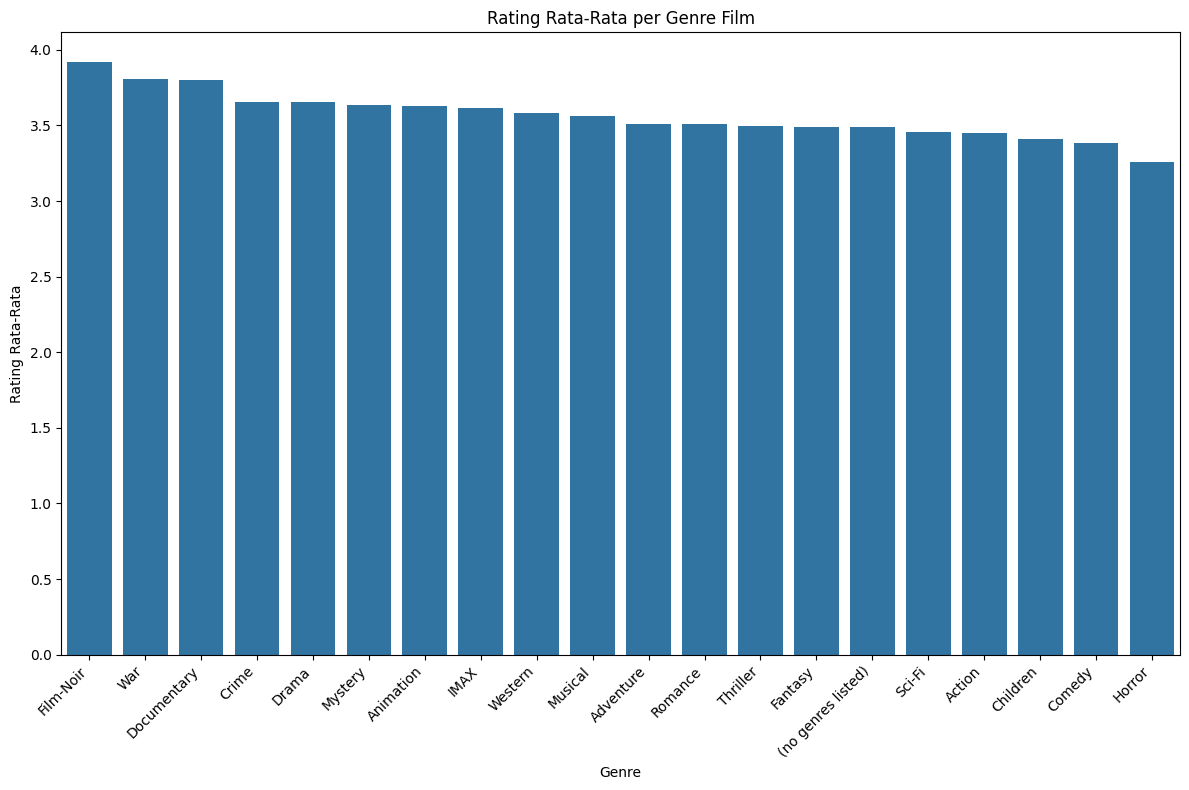

genre
Film-Noir             3.920115
War                   3.808294
Documentary           3.797785
Crime                 3.658294
Drama                 3.656184
Mystery               3.632460
Animation             3.629937
IMAX                  3.618335
Western               3.583938
Musical               3.563678
Adventure             3.508609
Romance               3.506511
Thriller              3.493706
Fantasy               3.491001
(no genres listed)    3.489362
Sci-Fi                3.455721
Action                3.447984
Children              3.412956
Comedy                3.384721
Horror                3.258195
Name: rating, dtype: float64


In [67]:
# Menggabungkan DataFrame movies dan ratings
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Membuat fungsi untuk memisahkan genre
def split_genres(genres_str):
  return genres_str.split('|')

# Menerapkan fungsi split_genres pada kolom genres
movie_ratings['genres_list'] = movie_ratings['genres'].apply(split_genres)

# Mengekstrak genre dan rating
genre_ratings = []
for index, row in movie_ratings.iterrows():
  for genre in row['genres_list']:
    genre_ratings.append([genre, row['rating']])

# Membuat DataFrame dari genre dan rating
genre_ratings_df = pd.DataFrame(genre_ratings, columns=['genre', 'rating'])

# Menghitung rating rata-rata per genre
avg_rating_per_genre = genre_ratings_df.groupby('genre')['rating'].mean().sort_values(ascending=False)

# Membuat visualisasi rating rata-rata per genre
plt.figure(figsize=(12, 8))
sns.barplot(x=avg_rating_per_genre.index, y=avg_rating_per_genre.values)
plt.title('Rating Rata-Rata per Genre Film')
plt.xlabel('Genre')
plt.ylabel('Rating Rata-Rata')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(avg_rating_per_genre)

Berdasarkan hasil output, berikut adalah beberapa genre dengan rating rata-rata tertinggi:

Film-Noir – 3.92

War – 3.80

Documentary – 3.79


Sementara genre dengan rating rata-rata lebih rendah termasuk:

Comedy – 3.38

Children – 3.41

Horror – 3.25

Dari hasil ini, dapat disimpulkan bahwa meskipun genre seperti Film-Noir dan War jarang muncul, mereka mendapatkan rata-rata rating yang tinggi, menunjukkan bahwa film-film dalam genre tersebut cenderung mendapat apresiasi tinggi dari pengguna. Sebaliknya, genre populer seperti Horror dan Children cenderung memiliki rating lebih rendah, kemungkinan karena variasi kualitas film yang lebih luas dalam genre tersebut.

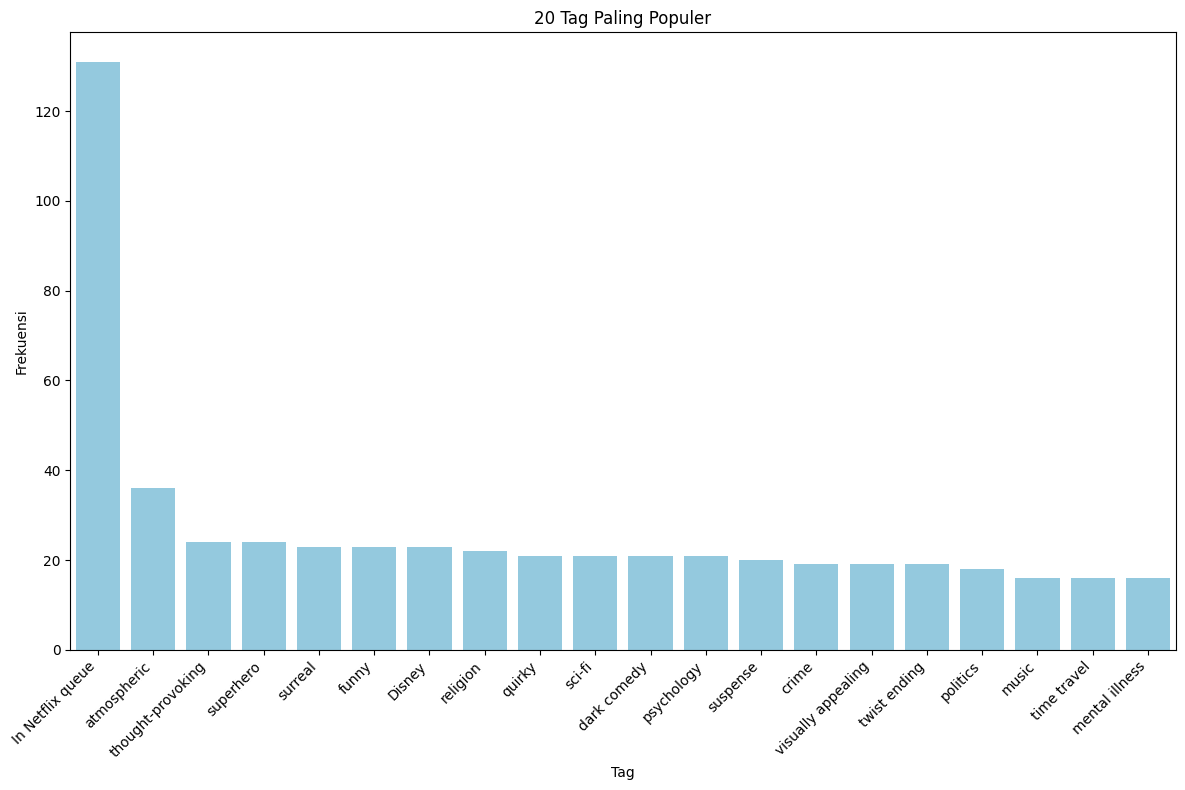

tag
In Netflix queue      131
atmospheric            36
thought-provoking      24
superhero              24
surreal                23
funny                  23
Disney                 23
religion               22
quirky                 21
sci-fi                 21
dark comedy            21
psychology             21
suspense               20
crime                  19
visually appealing     19
twist ending           19
politics               18
music                  16
time travel            16
mental illness         16
Name: count, dtype: int64


In [68]:
# Menghitung frekuensi setiap tag dan ambil 20 teratas
top_tags = tags['tag'].value_counts().head(20)

# Membuat visualisasi menggunakan seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x=top_tags.index, y=top_tags.values, color='skyblue')  # Menggunakan seaborn
plt.title('20 Tag Paling Populer')
plt.xlabel('Tag')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45, ha='right')  # Rotasi dan alignment label sumbu x
plt.tight_layout()  # Menyesuaikan tata letak
plt.show()

print(top_tags)  # Menampilkan data frekuensi tag

Dari hasil yang ditampilkan, tag "In Netflix queue" mendominasi sebagai tag paling populer, muncul sebanyak 131 kali. Hal ini mengindikasikan bahwa banyak pengguna memanfaatkan tag ini untuk menandai film yang ingin mereka tonton di Netflix. Tag-tag populer lainnya meliputi "atmospheric", "thought-provoking", "superhero", "surreal", "funny", dan "Disney", yang mencerminkan preferensi pengguna terhadap genre, suasana, atau tema film tertentu. Frekuensi tag menurun secara bertahap, dengan tag-tag di urutan bawah tabel muncul sekitar 16-19 kali. Informasi ini memberikan wawasan berharga tentang preferensi pengguna dan dapat dimanfaatkan untuk membangun sistem rekomendasi yang lebih akurat dan relevan.

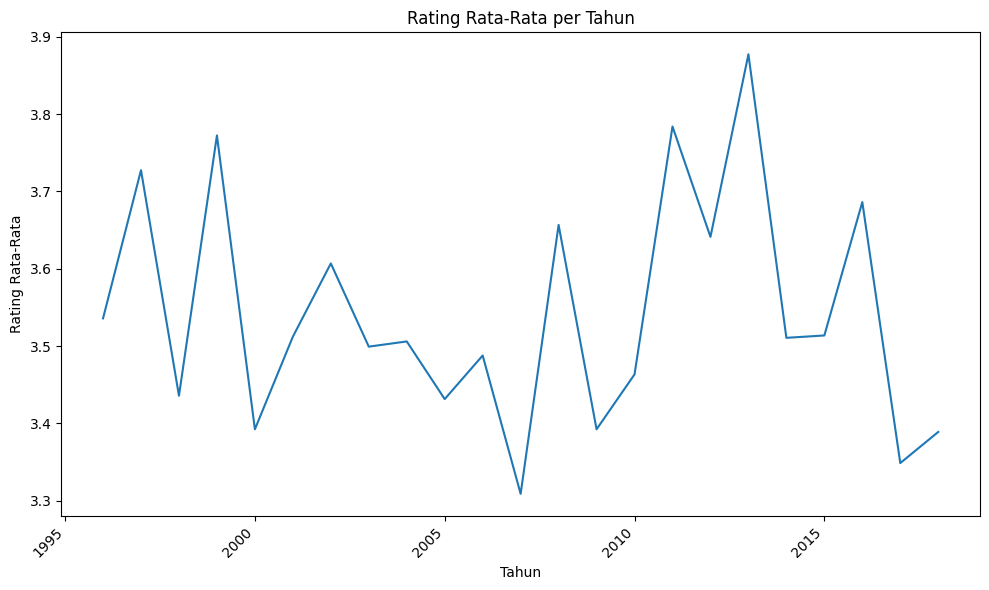

year
1996    3.535927
1997    3.727557
1998    3.435897
1999    3.772448
2000    3.392506
2001    3.512239
2002    3.606958
2003    3.499377
2004    3.506099
2005    3.431533
2006    3.487928
2007    3.309039
2008    3.656746
2009    3.392496
2010    3.463494
2011    3.784024
2012    3.641323
2013    3.877404
2014    3.510771
2015    3.513830
2016    3.686334
2017    3.348805
2018    3.389062
Name: rating, dtype: float64


In [69]:
# Mengubah timestamp menjadi datetime objects
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Mengekstrak tahun dari timestamp
ratings['year'] = ratings['timestamp'].dt.year

# Menghitung rating rata-rata per tahun
average_rating_per_year = ratings.groupby('year')['rating'].mean()

# Membuat visualisasi rating rata-rata per tahun
plt.figure(figsize=(10, 6))
plt.plot(average_rating_per_year.index, average_rating_per_year.values)
plt.title('Rating Rata-Rata per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Rating Rata-Rata')
plt.xticks(rotation=45, ha='right')  # Rotasi label sumbu x agar terbaca
plt.tight_layout()
plt.show()

# Menampilkan rating rata-rata per tahun
print(average_rating_per_year)

Dari hasil analisis, terlihat adanya fluktuasi rating rata-rata film dari tahun ke tahun. Meskipun tidak terdapat tren peningkatan atau penurunan yang konsisten, beberapa tahun menunjukkan rating rata-rata yang lebih tinggi dibandingkan tahun-tahun lainnya. Misalnya, tahun 1999 dan 2011 memiliki rating rata-rata yang relatif tinggi, sementara tahun 2007 dan 2017 menunjukkan rating rata-rata yang relatif rendah. Fluktuasi ini dapat dipengaruhi oleh berbagai faktor, seperti kualitas film yang dirilis pada tahun tersebut, preferensi pengguna yang berubah, atau bias dalam pengumpulan data. Informasi tentang tren rating dari waktu ke waktu ini dapat memberikan wawasan tambahan dalam memahami dinamika preferensi pengguna dan dapat dipertimbangkan dalam pengembangan sistem rekomendasi yang lebih adaptif.

Melalui eksplorasi dan visualisasi data di atas, kita telah memperoleh pemahaman yang lebih mendalam tentang karakteristik dataset MovieLens. Informasi ini akan menjadi dasar yang kuat untuk tahap selanjutnya, yaitu mempersiapkan data dan membangun model sistem rekomendasi film.

#Data Preparation

Setelah memahami karakteristik dataset MovieLens melalui tahap data understanding, langkah selanjutnya adalah mengolah dan menyusun data agar siap digunakan dalam proses pemodelan sistem rekomendasi. Tahap data preparation ini penting untuk memastikan bahwa model content-based filtering dan collaborative filtering yang akan dibangun dapat memanfaatkan informasi yang tersedia secara optimal.

Pada section ini, akan fokus pada dua proses utama:

1. Penggabungan Fitur Film: Menggabungkan informasi genre dan tag film menjadi satu kesatuan. Tujuannya adalah untuk menciptakan representasi film yang lebih komprehensif, yang mencakup informasi tentang kategori dan kata kunci yang terkait dengan film tersebut.

2. Penanganan Missing Values: Mengisi nilai yang hilang (missing values) pada kolom tag dengan string kosong. Hal ini dilakukan untuk memastikan bahwa semua film memiliki representasi tag, meskipun tag tersebut kosong.

Kedua proses ini akan menghasilkan dataset yang lebih terstruktur dan informatif, yang akan digunakan sebagai input untuk model sistem rekomendasi. Dengan menggabungkan genre dan tag, kita memberikan model akses ke informasi yang lebih kaya tentang setiap film. Penanganan missing values memastikan bahwa model dapat memproses semua data film tanpa terkendala oleh nilai yang hilang.

In [70]:
# Menggabungkan semua tag menjadi satu string per movieId, gunakan delimiter koma
all_tags = tags.groupby('movieId')['tag'].apply(lambda tags: ','.join(tags.astype(str))).reset_index()

# Menggabungkan movies dengan all_tags menggunakan merge
movies_with_all_tags = pd.merge(movies, all_tags, on='movieId', how='left')

# Mengisi nilai NaN di kolom 'tag' dengan string kosong
movies_with_all_tags['tag'] = movies_with_all_tags['tag'].fillna('')

# Menampilkan 5 baris pertama dari DataFrame
movies_with_all_tags.head()

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"pixar,pixar,fun"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"fantasy,magic board game,Robin Williams,game"
2,3,Grumpier Old Men (1995),Comedy|Romance,"moldy,old"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,
4,5,Father of the Bride Part II (1995),Comedy,"pregnancy,remake"


In [71]:
# Menggabungkan semua tag menjadi satu string per movieId, gunakan delimiter koma
all_tags = tags.groupby('movieId')['tag'].apply(lambda tags: ', '.join(tags.astype(str))).reset_index()

# Menggabungkan movies dengan all_tags menggunakan merge
movies_with_all_tags = pd.merge(movies, all_tags, on='movieId', how='left')

# Mengisi nilai NaN di kolom 'tag' dengan string kosong
movies_with_all_tags['tag'] = movies_with_all_tags['tag'].fillna('')

# Membuat kolom 'combined_features' yang menggabungkan genre dan tag dengan delimiter koma spasi
movies_with_all_tags['combined_features'] = movies_with_all_tags['genres'] + ', ' + movies_with_all_tags['tag']

# Menampilkan 5 baris pertama dari DataFrame
movies_with_all_tags.head()

,movieId,title,genres,tag,combined_features
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"pixar, pixar, fun","Adventure|Animation|Children|Comedy|Fantasy, p..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"fantasy, magic board game, Robin Williams, game","Adventure|Children|Fantasy, fantasy, magic boa..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"moldy, old","Comedy|Romance, moldy, old"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,,"Comedy|Drama|Romance,"
4,5,Father of the Bride Part II (1995),Comedy,"pregnancy, remake","Comedy, pregnancy, remake"


#Modeling and Result

Setelah data film, rating, dan tag dipersiapkan dengan matang pada tahap sebelumnya, kita memasuki tahap yang paling menarik, yaitu membangun dan menguji sistem rekomendasi film. Pada section Modeling and Result ini, kita akan mengimplementasikan dua pendekatan utama dalam sistem rekomendasi, yaitu Content-Based Filtering dan Collaborative Filtering, untuk memberikan rekomendasi film yang relevan dan personal kepada pengguna.

Langkah-langkah yang akan kita lalui dalam section ini meliputi:

1. Content-Based Filtering:


*   Membangun model yang merekomendasikan film berdasarkan kesamaan konten dengan film yang disukai pengguna sebelumnya.
*   Menggunakan teknik TF-IDF untuk merepresentasikan fitur film (genre dan tag) dalam bentuk vektor numerik.
Menghitung kesamaan antar film menggunakan Cosine Similarity.
*   Mengembangkan fungsi untuk menghasilkan rekomendasi film dan mengukur precision dari rekomendasi.

2. Collaborative Filtering:


*   Membangun model yang merekomendasikan film berdasarkan preferensi pengguna lain yang memiliki selera serupa.
*   Menggunakan teknik embedding untuk merepresentasikan pengguna dan film dalam ruang vektor laten.
*   Melatih model deep learning untuk memprediksi rating film yang belum ditonton oleh pengguna.
*   Mengembangkan fungsi untuk menghasilkan rekomendasi film berdasarkan prediksi rating.

3. Evaluasi dan Analisis:


*   Menganalisis kinerja model content-based filtering dan collaborative filtering berdasarkan hasil rekomendasi yang diberikan.
*   Membandingkan kedua pendekatan dan mengidentifikasi kelebihan dan kekurangan masing-masing.

Dengan mengimplementasikan dan mengevaluasi kedua pendekatan ini, kita akan memperoleh pemahaman yang lebih mendalam tentang bagaimana sistem rekomendasi film bekerja dan bagaimana kita dapat mengoptimalkannya untuk memberikan pengalaman yang lebih baik kepada pengguna.

##Content Based Filtering

### Data Preparation untuk Content Based Filtering

Sebelum membangun model content-based filtering, teks dalam combined_features (genre dan tag film) perlu diubah menjadi bentuk numerik. TF-IDF Vectorizer digunakan untuk melakukan preprocessing ini dan menghasilkan representasi numerik dari fitur film.

In [72]:
# Inisialisasi TF-IDF Vectorizer dengan stop words bahasa Inggris
vectorizer = TfidfVectorizer(stop_words='english')

# Fit dan transform data 'combined_features' ke dalam matriks TF-IDF
tfidf_matrix = vectorizer.fit_transform(movies_with_all_tags['combined_features'])

# Dapatkan nama-nama fitur (kata-kata)
feature_names = vectorizer.get_feature_names_out()

# (Opsional) Tampilkan matriks TF-IDF dan nama fitur
print(tfidf_matrix)
print(feature_names)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 27876 stored elements and shape (9742, 1677)>
  Coords	Values
  (0, 36)	0.14923127385752047
  (0, 75)	0.18490545901063682
  (0, 274)	0.18038846066758712
  (0, 317)	0.09576778805506665
  (0, 530)	0.17300098313924464
  (0, 1142)	0.8416771249174413
  (0, 587)	0.40432512831075756
  (1, 36)	0.11462426795143799
  (1, 274)	0.13855604603797955
  (1, 530)	0.26576347617521395
  (1, 925)	0.30552767912025
  (1, 177)	0.3577865894015698
  (1, 595)	0.6850036759600162
  (1, 1263)	0.33165713426090987
  (1, 1651)	0.31056139004241473
  (2, 317)	0.14088088145157518
  (2, 1271)	0.2026249156281861
  (2, 992)	0.6852356240039252
  (2, 1081)	0.6852356240039252
  (3, 317)	0.5048999073185984
  (3, 1271)	0.7261829999003466
  (3, 453)	0.4666201177032598
  (4, 317)	0.17051503723707886
  (4, 1172)	0.7199029622585923
  (4, 1235)	0.6728033494323146
  :	:
  (9732, 75)	0.21879993106093945
  (9732, 317)	0.22664539528929592
  (9732, 22)	0.15512521431325352
  (9

Blok kode ini menghitung kesamaan antar film menggunakan Cosine Similarity berdasarkan representasi numerik yang telah dibuat sebelumnya, menghasilkan matriks yang menunjukkan tingkat kesamaan setiap pasangan film.

In [73]:
# Menghitung cosine similarity antara semua pasangan film
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# (Opsional) Menampilkan matriks cosine similarity
print(cosine_sim_matrix)

[[1.         0.08807678 0.01349185 ... 0.         0.15084122 0.09576779]
 [0.08807678 1.         0.         ... 0.         0.         0.        ]
 [0.01349185 0.         1.         ... 0.         0.         0.14088088]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.15084122 0.         0.         ... 0.         1.         0.        ]
 [0.09576779 0.         0.14088088 ... 0.         0.         1.        ]]


### Pembuatan Model Content Based Filtering

Blok kode ini mendefinisikan fungsi get_movie_recommendations yang menerima judul film sebagai input dan menghasilkan DataFrame berisi rekomendasi film yang paling mirip berdasarkan kesamaan kosinus.

In [74]:
def get_movie_recommendations(movie_title, movies_with_all_tags, cosine_sim_matrix, top_n=10):
    """
    Mendapatkan rekomendasi film berdasarkan judul film.

    Args:
        movie_title: Judul film yang ingin dicari rekomendasinya.
        movies_with_all_tags: DataFrame yang berisi informasi film dan tag.
        cosine_sim_matrix: Matriks cosine similarity antara film.
        top_n: Jumlah rekomendasi film yang ingin ditampilkan (default: 10).

    Returns:
        DataFrame yang berisi rekomendasi film.
    """

    # Mendapatkan indeks film yang sesuai dengan judul
    movie_index = movies_with_all_tags[movies_with_all_tags['title'] == movie_title].index[0]

    # Mendapatkan skor kesamaan untuk semua film dengan film input
    similarity_scores = list(enumerate(cosine_sim_matrix[movie_index]))

    # Mengurutkan film berdasarkan skor kesamaan
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Mendapatkan skor untuk top_n film teratas dan diri sendiri
    similarity_scores = similarity_scores[1:top_n + 1]

    # Mendapatkan indeks film yang direkomendasikan
    movie_indices = [i[0] for i in similarity_scores]

    # Mengembalikan DataFrame yang berisi rekomendasi film
    recommendations = movies_with_all_tags.iloc[movie_indices][['title', 'genres', 'tag']]
    recommendations['similarity_score'] = [i[1] for i in similarity_scores]

    return recommendations

Blok kode ini mendefinisikan fungsi calculate_precision yang menghitung precision dari rekomendasi film yang dihasilkan oleh sistem content-based filtering, dengan membandingkan genre film target dengan genre film yang direkomendasikan.

In [75]:
def calculate_precision(movie_title, movies_with_all_tags, cosine_sim_matrix, top_n=10):
    """
    Menghitung precision untuk rekomendasi film berdasarkan judul film.

    Args:
        movie_title: Judul film yang ingin dihitung precision-nya.
        movies_with_all_tags: DataFrame yang berisi informasi film dan tag.
        cosine_sim_matrix: Matriks cosine similarity antara film.
        top_n: Jumlah rekomendasi film teratas yang dipertimbangkan (default: 10).

    Returns:
        Nilai precision.
    """
    # Mendapatkan indeks film yang sesuai dengan judul
    movie_index = movies_with_all_tags[movies_with_all_tags['title'] == movie_title].index[0]

    # Mendapatkan skor kesamaan untuk semua film dengan film input
    similarity_scores = list(enumerate(cosine_sim_matrix[movie_index]))

    # Mengurutkan film berdasarkan skor kesamaan
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Mendapatkan skor untuk top_n film teratas dan diri sendiri
    similarity_scores = similarity_scores[1:top_n + 1]

    # Mendapatkan indeks film yang direkomendasikan
    movie_indices = [i[0] for i in similarity_scores]

    # Mendapatkan genre film target
    target_genres = set(movies_with_all_tags.loc[movie_index, 'genres'].split('|'))

    # Menghitung jumlah rekomendasi yang relevan (memiliki genre yang sama)
    relevant_recommendations = 0
    for i in movie_indices:
        recommended_genres = set(movies_with_all_tags.loc[i, 'genres'].split('|'))
        if len(target_genres.intersection(recommended_genres)) > 0:
            relevant_recommendations += 1

    # Menghitung precision
    precision = relevant_recommendations / top_n

    return precision

### Result dan Evaluasi Content Based Filtering

Langkah ini bertujuan untuk menguji dan mengevaluasi sistem rekomendasi content-based filtering yang telah kita bangun. Pengujian dilakukan dengan memilih film secara acak dari dataset dan menggunakan sistem untuk menghasilkan rekomendasi film yang mirip.

Pertama, sebuah film dipilih secara acak sebagai target rekomendasi. Kemudian, sistem akan mencari film-film lain yang memiliki kesamaan dengan film target berdasarkan genre dan tag yang telah diproses menggunakan TF-IDF dan cosine similarity. Setelah itu, sistem akan menampilkan informasi tentang film target, termasuk judul, genre, dan tag-nya.

Selanjutnya, sistem akan menampilkan daftar film yang direkomendasikan, beserta judul, genre, tag, dan skor kesamaan (similarity score) dengan film target. Skor kesamaan menunjukkan seberapa mirip film yang direkomendasikan dengan film target.

Terakhir, sistem akan menghitung dan menampilkan nilai precision untuk mengukur relevansi rekomendasi yang dihasilkan. Precision dihitung dengan membandingkan genre film target dengan genre film-film yang direkomendasikan. Semakin tinggi nilai precision, semakin banyak film yang direkomendasikan memiliki genre yang sama dengan film target, yang mengindikasikan relevansi yang lebih tinggi.

In [86]:
# Memilih film acak dari dataset
random_movie = random.choice(movies_with_all_tags['title'].tolist())

# Mendapatkan informasi genre dan tag untuk film yang dipilih
selected_movie_genres = movies_with_all_tags[movies_with_all_tags['title'] == random_movie]['genres'].values[0]
selected_movie_tags = movies_with_all_tags[movies_with_all_tags['title'] == random_movie]['tag'].values[0]

# Mendapatkan rekomendasi untuk film yang dipilih
recommendations = get_movie_recommendations(random_movie, movies_with_all_tags, cosine_sim_matrix, top_n=10)

# Menampilkan judul film yang dipilih dan rekomendasinya
print(f"Rekomendasi untuk film: {random_movie}\n")
print(f"Genre: {selected_movie_genres}")
print(f"Tag: {selected_movie_tags}\n")
print(recommendations[['title', 'genres', 'tag', 'similarity_score']])

# Menghitung precision
precision = calculate_precision(random_movie, movies_with_all_tags, cosine_sim_matrix, top_n=10)

# Menampilkan nilai precision
print(f"\nPrecision: {precision}")

Rekomendasi untuk film: Five Deadly Venoms (1978)

Genre: Action
Tag: 

                                                  title  genres tag  \
63                                     Fair Game (1995)  Action       
172                Under Siege 2: Dark Territory (1995)  Action       
215                                  Hunted, The (1995)  Action       
555   Bloodsport 2 (a.k.a. Bloodsport II: The Next K...  Action       
876          Best of the Best 3: No Turning Back (1995)  Action       
1143                                 Double Team (1997)  Action       
1201                                       Steel (1997)  Action       
1647                                   Knock Off (1998)  Action       
1910                                   Avalanche (1978)  Action       
2120                        Aces: Iron Eagle III (1992)  Action       

      similarity_score  
63                 1.0  
172                1.0  
215                1.0  
555                1.0  
876                1.

##Collaborative Filtering

### Data Preparation untuk Collaborative Filtering

Pada tahap pertama ini, menyiapkan data rating agar bisa dipakai oleh algoritma collaborative filtering. Pertama, data rating asli dicopy agar data aslinya tetap aman.

Lalu, ID pengguna dan ID film diubah menjadi angka berurutan. Algoritma collaborative filtering butuh data angka, makanya diubah.

Selanjutnya, dibuat daftar yang menghubungkan ID asli dengan ID angka. ID angka ini dimasukkan ke kolom baru di data rating.

Terakhir, dihitung jumlah pengguna dan film, dan dipastikan kolom rating berisi angka desimal. Semua ini dilakukan agar data siap dipakai oleh algoritma collaborative filtering.

In [77]:
# Membuat salinan DataFrame ratings untuk menghindari modifikasi data asli
ratings_cf = ratings.copy()

# Mengubah userId dan movieId menjadi kategori yang berurutan
user_ids = ratings_cf['userId'].unique().tolist()
movie_ids = ratings_cf['movieId'].unique().tolist()

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

ratings_cf['user'] = ratings_cf['userId'].map(user_to_user_encoded)
ratings_cf['movie'] = ratings_cf['movieId'].map(movie_to_movie_encoded)

num_users = len(user_to_user_encoded)
num_movies = len(movie_to_movie_encoded)
ratings_cf['rating'] = ratings_cf['rating'].astype(float)

Kode ini menampilkan jumlah total pengguna dan film yang ada dalam dataset. Informasi ini didapat dari variabel num_users dan num_movies yang telah dihitung sebelumnya. Dengan menampilkan jumlah pengguna dan film, kita mendapatkan gambaran tentang skala data yang akan digunakan dalam sistem rekomendasi. Hal ini penting untuk memahami kompleksitas dan kebutuhan komputasi dari model yang akan dibangun.

In [78]:
print(f"Jumlah pengguna: {num_users}")
print(f"Jumlah film: {num_movies}")

Jumlah pengguna: 610
Jumlah film: 9724


Selanjutnya mempersiapkan data untuk pelatihan dan evaluasi model collaborative filtering. Pertama, data rating dibagi menjadi dua bagian: data latih (train_data) dan data validasi (test_data). Pembagian ini menggunakan fungsi train_test_split dari scikit-learn, dengan 80% data digunakan untuk pelatihan dan 20% untuk validasi.

Selanjutnya, data latih dan data validasi dipisahkan menjadi fitur (X) dan target (y). Fitur adalah data input untuk model, yaitu user dan movie (ID pengguna dan ID film yang telah di-encode). Target adalah data yang ingin diprediksi oleh model, yaitu rating.

Data latih dan data validasi dalam bentuk fitur dan target ini akan digunakan untuk melatih dan mengevaluasi model collaborative filtering yang akan dibangun.

In [79]:
# Membagi data menjadi set latih dan validasi
train_data, test_data = train_test_split(ratings_cf, test_size=0.2, random_state=42)

# Membuat dataset untuk model
X_train = train_data[['user', 'movie']].values
y_train = train_data['rating'].values

X_test = test_data[['user', 'movie']].values
y_test = test_data['rating'].values

### Pembuatan Model Collaborative Filtering

Mendefinisikan fungsi MovieRecommender untuk membangun model collaborative filtering dengan deep learning. Model ini menggunakan embedding untuk merepresentasikan pengguna dan film, serta dense layer dan dropout untuk memprediksi rating. Kemudian, fungsi tersebut dipanggil untuk membuat model model dengan jumlah pengguna dan film yang telah dihitung sebelumnya.

In [80]:
def MovieRecommender(num_users, num_movies, embedding_dim=64):
    # Input layers
    user_in = Input(shape=(1,), name='user_input')
    movie_in = Input(shape=(1,), name='movie_input')

    # Embedding layers dengan regularisasi
    user_embed = Embedding(num_users, embedding_dim, name='user_embedding', embeddings_regularizer=l2(0.001))(user_in)
    movie_embed = Embedding(num_movies, embedding_dim, name='movie_embedding', embeddings_regularizer=l2(0.001))(movie_in)

    # Flatten the embeddings
    user_vec = Flatten(name='flatten_users')(user_embed)
    movie_vec = Flatten(name='flatten_movies')(movie_embed)

    # Concatenate user and movie vectors
    merged = Concatenate()([user_vec, movie_vec])

    # Dense layer dengan dropout
    hidden = Dense(256, activation='relu')(merged)
    dropout_layer = Dropout(0.3)(hidden)
    out = Dense(1)(dropout_layer)

    # Create the model
    rec_model = Model(inputs=[user_in, movie_in], outputs=out)

    # Compile the model
    rec_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return rec_model

# Contoh membuat model dengan modifikasi
model = MovieRecommender(num_users, num_movies)

Melatih model collaborative filtering yang telah didefinisikan sebelumnya menggunakan data latih (X_train, y_train). Proses pelatihan dilakukan selama 10 epoch dengan ukuran batch 64, dan kinerja model dievaluasi menggunakan data validasi (X_test, y_test).

In [81]:
# Training model
history = model.fit(
    x=[X_train[:, 0], X_train[:, 1]],
    y=y_train,
    epochs=10,
    batch_size=64,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test)
)

Epoch 1/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 2.6940 - mae: 1.1649 - val_loss: 0.9036 - val_mae: 0.6952
Epoch 2/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.8800 - mae: 0.6880 - val_loss: 0.8715 - val_mae: 0.6768
Epoch 3/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.8388 - mae: 0.6720 - val_loss: 0.8479 - val_mae: 0.6671
Epoch 4/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.8087 - mae: 0.6561 - val_loss: 0.8405 - val_mae: 0.6698
Epoch 5/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.7795 - mae: 0.6434 - val_loss: 0.8383 - val_mae: 0.6599
Epoch 6/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.7571 - mae: 0.6320 - val_loss: 0.8346 - val_mae: 0.6707
Epoch 7/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.7496 - mae: 0.6298 - val_loss: 0.8343 - val_mae: 0.6677
Epoch 8/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.7300 - mae: 0.6194 - val_loss: 0.8283 - val_mae: 0.6625
Epoch 9/10
1261/1261 ━━━

### Result dan Evaluasi Collaborative Filtering

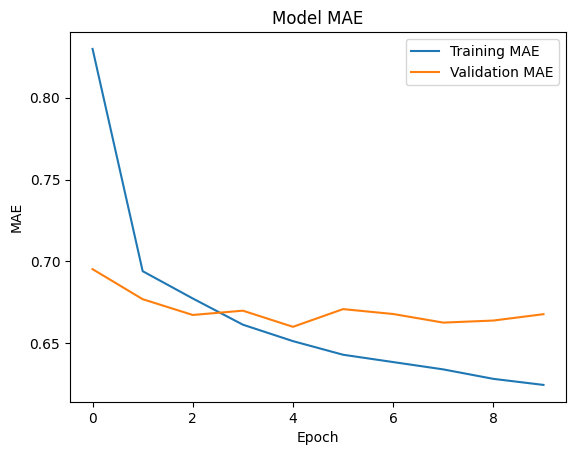

In [82]:
# Plot training and validation MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Membuat pemetaan (mapping) antara ID pengguna/film asli dengan ID yang telah di-encode (encoded) untuk collaborative filtering. Pemetaan ini memungkinkan konversi bolak-balik antara ID asli dan ID encoded, yang dibutuhkan untuk menghasilkan rekomendasi dan interpretasi hasil.

In [83]:
# Pemetaan untuk user dan movie
all_user_ids = ratings['userId'].unique().tolist()
user_to_encoded = {x: i for i, x in enumerate(all_user_ids)}
encoded_to_user = {i: x for i, x in enumerate(all_user_ids)}

all_movie_ids = ratings['movieId'].unique().tolist()
movie_to_encoded = {x: i for i, x in enumerate(all_movie_ids)}
encoded_to_movie = {i: x for i, x in enumerate(all_movie_ids)}

Mendefinisikan fungsi collaborative_filtering_recommendation yang menerima ID pengguna dan jumlah rekomendasi sebagai input. Fungsi ini menggunakan model collaborative filtering yang telah dilatih untuk memprediksi rating film yang belum ditonton oleh pengguna, dan menghasilkan DataFrame berisi rekomendasi film berdasarkan prediksi rating tertinggi.

In [84]:
def collaborative_filtering_recommendation(model, user_id, num_recommendations=10):
    # Periksa apakah user_id perlu di-encode
    # Jika perlu, gunakan struktur data yang sesuai untuk mencari kode pengguna
    user_encoded = user_to_encoded.get(user_id)
    if user_encoded is None:
        raise ValueError("UserID not found in encoded user IDs.")

    # Menyiapkan movie_ids yang belum ditonton oleh user
    movie_ids = np.setdiff1d(movies['movieId'].unique(), ratings[ratings['userId'] == user_id]['movieId'])

    # Encoding movie_ids
    movie_ids_encoded = [movie_to_encoded.get(x) for x in movie_ids if movie_to_encoded.get(x) is not None]

    user_encoded_array = np.array([user_encoded] * len(movie_ids_encoded))
    movie_ids_encoded_array = np.array(movie_ids_encoded)

    # Melakukan prediksi
    predictions = model.predict([user_encoded_array, movie_ids_encoded_array])

    # Mendapatkan rekomendasi berdasarkan prediksi rating tertinggi
    top_ratings_indices = predictions.flatten().argsort()[-num_recommendations:][::-1]
    recommended_movie_ids_encoded = [movie_ids_encoded_array[x] for x in top_ratings_indices]

    # Mendapatkan movieId asli dari rekomendasi
    recommended_movie_ids = [encoded_to_movie.get(movie_encoded) for movie_encoded in recommended_movie_ids_encoded]

    return movies[movies['movieId'].isin(recommended_movie_ids)]

#### Menjalankan Fungsi Rekomendasi

Menguji fungsi collaborative_filtering_recommendation dengan memilih pengguna secara acak, menghasilkan rekomendasi film untuk pengguna tersebut, dan menampilkan hasilnya dalam bentuk tabel. Selain itu, blok kode ini juga menampilkan film teratas yang pernah dinilai oleh pengguna tersebut sebagai pembanding.

In [85]:
# Memilih user secara acak
random_user_id = random.choice(ratings['userId'].unique())

# Dapatkan rekomendasi film
recommendations_cf = collaborative_filtering_recommendation(model, random_user_id, num_recommendations=5)

# Tampilkan film teratas yang dinilai oleh user
top_rated_movies = ratings[ratings['userId'] == random_user_id].sort_values(by='rating', ascending=False).head(3)
top_rated_movies_info = pd.merge(top_rated_movies, movies, on='movieId')[['title', 'genres', 'rating']]

# Tampilkan hasil dalam bentuk tabel
print(f"Rekomendasi untuk user {random_user_id}:")
print("\nFilm teratas yang dinilai:")
display(top_rated_movies_info.style.set_caption("Top 3 Rated Movies"))  # Menggunakan style untuk tampilan tabel

print("\nRekomendasi film:")
display(recommendations_cf[['title', 'genres']].style.set_caption("Recommended Movies"))  # Menggunakan style untuk tampilan tabel

303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Rekomendasi untuk user 366:

Film teratas yang dinilai:


,title,genres,rating
0,Reservoir Dogs (1992),Crime|Mystery|Thriller,5.000000
1,Interstellar (2014),Sci-Fi|IMAX,5.000000
2,Fight Club (1999),Action|Crime|Drama|Thriller,4.500000



Rekomendasi film:


,title,genres
277,"Shawshank Redemption, The (1994)",Crime|Drama
883,Paths of Glory (1957),Drama|War
918,Ran (1985),Drama|War
1762,"Celebration, The (Festen) (1998)",Drama
9618,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
